This notebook implements a simple viscoelastoplastic model.
The model setup follows Gerya's Problem 13.1
- VEP block, 100x60 km embedded in a medium.
- 100x100 km domain
- Isothermal
- Boundaries have prescribed normal velocity, free slip tangential velocity.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Profile
using ProfileVega
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("StokesVE.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [2]:
# Functions related to problem setup
struct Materials
    # 1 - weak inclusion
    # 2 - VEP block
    # 3 - weak medium
    alpha::Vector{Float64} # thermal expansivity
    rho0::Vector{Float64}  # reference density
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    mu::Vector{Float64} # elastic shear modulus
    cohesion::Vector{Float64}
    friction::Vector{Float64}
    function Materials()
         # values used in viscoelastoplastic block model
         new([0.0,0.0,0.0],[4000.0,4000.0,1.0],[0.0,0.0,0.0],[1e3,1e3,1e3],[2.0,2.0,2.0],[1e17,1e23,1e17],[1e11,1e11,1e11],[1e7,1e8,1e7],[0.0,0.6,0.0])
    end
end

function iinv(axx::Float64,axy::Float64)
    # compute the second deviatoric invariant
    # assumes axx=-ayy and axy=ayx
    return sqrt.( axx.^2 .+ axy.^2  )
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    # T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    mu = markers.scalarFields["mu"]
    rho = markers.scalarFields["rho"]
    # alpha = markers.scalarFields["alpha"]
    # cp = markers.scalarFields["Cp"]
    # kThermal = markers.scalarFields["kThermal"]
    # Hr = markers.scalarFields["Hr"]
    cohesion = markers.scalarFields["cohesion"]
    friction = markers.scalarFields["friction"]
    exx = markers.scalarFields["exx"]
    exy = markers.scalarFields["exy"]
    sxx = markers.scalarFields["sxx"]
    sxy = markers.scalarFields["sxy"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mmat::Int64 = 0
        if mx > 4.5e4 && mx < 5.5e4 && my > 4.5e4 && my < 5.5e4
            mmat = 1            
        elseif my > 0.2e5 && my < 0.8e5
            mmat = 2
        else
            mmat = 3
        end
                
        # beam
        markers.integers[material,i] = mmat
        # markers.scalars[T,i] = 0.0
        # markers.scalars[kThermal,i] = materials.kThermal[mmat]
        markers.scalars[eta,i] = materials.eta[mmat]
        markers.scalars[mu,i] = materials.mu[mmat]
        markers.scalars[rho,i] = materials.rho0[mmat]
        # markers.scalars[alpha,i] = materials.alpha[mmat]  
        # markers.scalars[cp,i] = materials.Cp[mmat]  
        # markers.scalars[Hr,i] = materials.Hr[mmat]
        # initialize stress/strain
        markers.scalars[cohesion,i] = materials.cohesion[mmat]
        markers.scalars[friction,i] = materials.friction[mmat]
        markers.scalars[sxx,i] = 0.0
        markers.scalars[sxy,i] = 0.0
        markers.scalars[exx,i] = 0.0
        markers.scalars[exy,i] = 0.0    
    end
end


initial_conditions! (generic function with 1 method)

In [3]:
# Functions related to stress and strain on the markers
function compute_ve_strainrate(grid::CartesianGrid,vx::Matrix{Float64},vy::Matrix{Float64})
    # This function assumes that flow is incompressible and we are computing a deviatoric strain-rate tensor    
    exy = zeros(grid.ny,grid.nx)
    for i in 1:grid.ny
        for j in 1:grid.nx
            exy[i,j] = 0.5*( (vx[i+1,j]-vx[i,j])/(grid.yc[i+1]-grid.yc[i]) + (vy[i,j+1]-vy[i,j])/(grid.xc[j+1]-grid.xc[j]) )
        end
    end
    exx = zeros(grid.ny+1,grid.nx+1)
    for i in 2:grid.ny
        for j in 2:grid.nx
            # This follows Gerya's equation 13.13, which assumes ezz'=0, but allows compressibility.
            exx[i,j] = 0.5*( (vx[i,j]-vx[i,j-1])/(grid.x[j]-grid.x[j-1]) - (vy[i,j]-vy[i-1,j])/(grid.y[i]-grid.y[i-1]) )
        end
    end
    return exx,exy
end

function compute_nodal_stress(eta_n::Matrix{Float64},eta_s::Matrix{Float64},mu_n::Matrix{Float64},mu_s::Matrix{Float64},
        sxx0::Matrix{Float64},sxy0::Matrix{Float64},exx::Matrix{Float64},exy::Matrix{Float64},dt::Float64)
    Zn = eta_n./(mu_n.*dt .+ eta_n)
    Zs = eta_s./(mu_s.*dt .+ eta_s)    
    sxx = 2.0.*mu_n.*dt.*Zn.*exx .+ (sxx0.*Zn)
    sxy = 2.0.*mu_s.*dt.*Zs.*exy .+ (sxy0.*Zs)
    return sxx,sxy
end

function rotate_stresses(sxx::Float64,sxy::Float64,theta::Float64)
    # Note - these formulae assume that we are working with the deviatoric stress tensor. Hence sxx = -syy.
    sxx_new::Float64 = sxx*cos(theta)^2 + (-sxx)*sin(theta)^2 - sxy*sin(2.0*theta)
    sxy_new::Float64 = 0.5*(sxx - -sxx)*sin(2.0*theta) + sxy*cos(2.0*theta)
    return sxx_new,sxy_new
end


function move_markers_rk4!(markers::Markers,grid::CartesianGrid,bc::BoundaryConditions,vx::Matrix{Float64},vy::Matrix{Float64},wxy::Matrix{Float64},dt::Float64; continuity_weight::Float64=1.0/3.0)
    # This function implements the 4th-order Runge-Kutta scheme for advection of markers. It expects
    # vx and vy are the velocities at the velocity nodes
    # dt is the timestep
    # this version computes the rotation on the markers and updates the stresses.
    if continuity_weight != 0.0
        vxc,vyc = velocity_to_centers(grid,vx,vy,bc)
    else
        vxc=nothing
        vyc=nothing
    end
    # 1. compute velocity at point A
    vxA::Vector{Float64}, vyA::Vector{Float64} = velocity_to_markers(markers,grid,bc,vx,vy,continuity_weight=continuity_weight,vxc=vxc,vyc=vyc)
    wA = stag_to_points(markers.x[:,1:markers.nmark],markers.cell[:,1:markers.nmark],grid,wxy,0,0)
    # 2. compute xB=xA + vA*dt/2
    xB = Array{Float64,2}(undef,2,markers.nmark)
    for i in 1:markers.nmark
        xB[1,i] = markers.x[1,i] + dt/2*vxA[i]
        xB[2,i] = markers.x[2,i] + dt/2*vyA[i]
    end
    # 3. locate xB and compute vxB
    cell::Matrix{Int64} = copy(markers.cell[:,1:markers.nmark])
    Threads.@threads for i in 1:markers.nmark
        cell[1,i] = find_cell(xB[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xB[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    vxB, vyB = velocity_to_points(xB,cell,grid,bc,vx,vy,continuity_weight=continuity_weight,vxc=vxc,vyc=vyc,N=markers.nmark)
    wB = stag_to_points(xB,cell,grid,wxy,0,0)
    # 4. compute xC = xA+vB*dt/2
    xC = Array{Float64,2}(undef,2,markers.nmark)
    for i in 1:markers.nmark
        xC[1,i] = markers.x[1,i] + dt/2*vxB[i]
        xC[2,i] = markers.x[2,i] + dt/2*vyB[i]
    end
    # 5. locate cells for xC and compute vC
    Threads.@threads for i in 1:markers.nmark
        cell[1,i] = find_cell(xC[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xC[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    vxC, vyC = velocity_to_points(xC,cell,grid,bc,vx,vy,continuity_weight=continuity_weight,vxc=vxc,vyc=vyc,N=markers.nmark)
    wC = stag_to_points(xC,cell,grid,wxy,0,0)
    # 6. compute xD = xA + vC*dt
    xD = Array{Float64,2}(undef,2,markers.nmark)
    for i in 1:markers.nmark
        xD[1,i] = markers.x[1,i] + dt*vxC[i]
        xD[2,i] = markers.x[2,i] + dt*vyC[i]
    end
    # 7. locate cells for xD and compute vD
    Threads.@threads for i in 1:markers.nmark
        cell[1,i] = find_cell(xD[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xD[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    vxD, vyD = velocity_to_points(xD,cell,grid,bc,vx,vy,continuity_weight=continuity_weight,vxc=vxc,vyc=vyc,N=markers.nmark)
    wD = stag_to_points(xD,cell,grid,wxy,0,0)
    # 8. Compute v_eff = 1/6*(vA+2*vB+2*vC+vD) and move markers by v_eff*dt
    Threads.@threads for i in 1:markers.nmark
        markers.x[1,i] += dt/6.0*(vxA[i] + 2*vxB[i] + 2*vxC[i] + vxD[i]) 
        markers.x[2,i] += dt/6.0*(vyA[i] + 2*vyB[i] + 2*vyC[i] + vyD[i])        
    end
    
    wA .= 1.0/6.0*(wA .+ 2. *wB .+ 2. *wC .+ wD)
    isxx::Int64 = markers.scalarFields["sxx"]
    msxx = markers.scalars[isxx,:]
    isxy::Int64 = markers.scalarFields["sxy"]
    msxy = markers.scalars[isxy,:]
    for i in 1:markers.nmark
        msxx1,msxy1 = rotate_stresses(msxx[i],msxy[i],wA[i]*dt) # compute the new stresses
        markers.scalars[isxx,i] = msxx1 # update the stress on the marker
        markers.scalars[isxy,i] = msxy1
    end
    
    # 9. relocate markers in their cells.
    find_cells!(markers,grid)
end

move_markers_rk4! (generic function with 2 methods)

In [4]:
# Functions related to plotting:
function plot_material(markers::Markers)
    # Visualize the materials:
    figure()
    nmark = markers.nmark
    scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=markers.integers[markers.integerFields["material"],1:nmark],s=0.01)
    axis("equal")
    colorbar()
    show()
end

function plot_rheology(markers::Markers)
    # plot viscosity and shear modulus
    f,(ax1,ax2) = subplots(1,2)
    
    nmark = markers.nmark
    h1 = ax1.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=log10.(markers.scalars[markers.scalarFields["eta"],1:nmark]),s=0.01)
    ax1.set_aspect("equal")
    colorbar(h1,ax=ax1)
    ax1.set_title("log10(eta)")
    ax1.invert_yaxis()
    h2=ax2.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=log10.(markers.scalars[markers.scalarFields["mu"],1:nmark]),s=0.01)
    ax2.set_aspect("equal")
    colorbar(h2,ax=ax2)
    ax2.set_title("log10(mu)")
    ax2.invert_yaxis()
end

function plot_stress(markers::Markers)
    # plot viscosity and shear modulus
    f,(ax1,ax2) = subplots(1,2)
    
    nmark = markers.nmark
    h1 = ax1.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=(markers.scalars[markers.scalarFields["sxx"],1:nmark]),s=0.01)
    ax1.set_aspect("equal")
    colorbar(h1,ax=ax1)
    ax1.set_title("sxx")
    h2=ax2.scatter(markers.x[1,1:nmark],markers.x[2,1:nmark],c=(markers.scalars[markers.scalarFields["sxy"],1:nmark]),s=0.01)
    ax2.set_aspect("equal")
    colorbar(h2,ax=ax2)
    ax2.set_title("sxy")
end

plot_stress (generic function with 1 method)

Creating Markers...
  0.000935 seconds (33 allocations: 35.537 MiB)
Initial condition...
  0.003893 seconds
Writing visualization fle inclusion/viz.0000.vtr
  0.000450 seconds (2 allocations: 3.433 MiB)
Min/Max velocity: -5.059444648069309e-9 5.059446527865221e-9
Finished Step 1 time=64.09127428528919 yr
Writing visualization fle inclusion/viz.0001.vtr
  0.000489 seconds (2 allocations: 3.433 MiB)
Min/Max velocity: -5.061914038944833e-9 5.061870700813813e-9
Finished Step 2 time=128.16666513071556 yr
Writing visualization fle inclusion/viz.0002.vtr
  0.000426 seconds (2 allocations: 3.433 MiB)
Min/Max velocity: -5.064037771878933e-9 5.0639787985334615e-9
Finished Step 3 time=192.2284507479363 yr
  3.655158 seconds (10.81 k allocations: 1.065 GiB, 0.29% gc time, 0.05% compilation time)


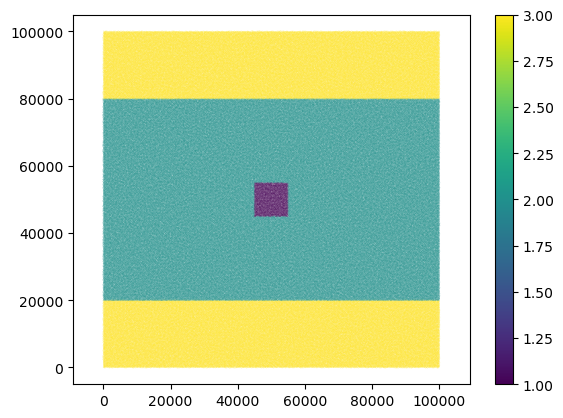

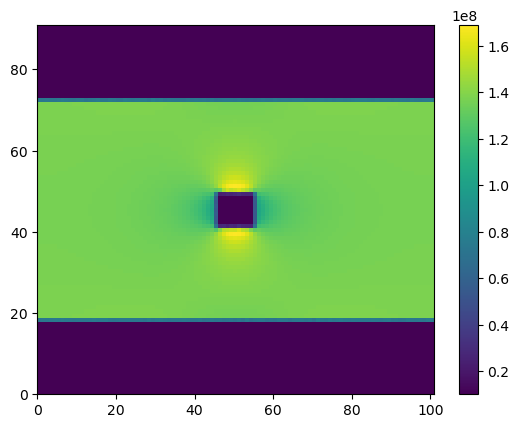

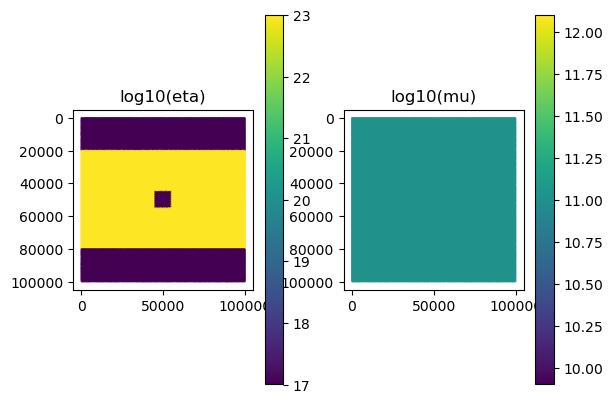

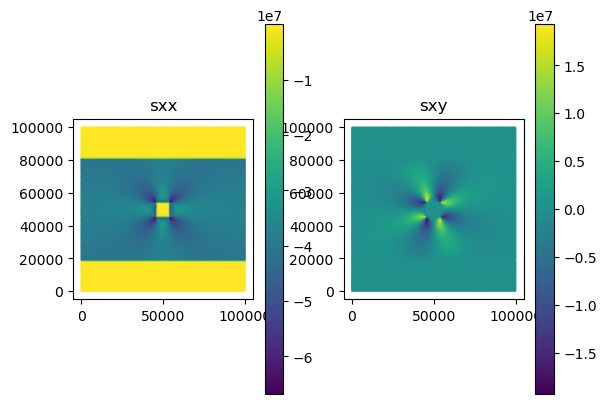

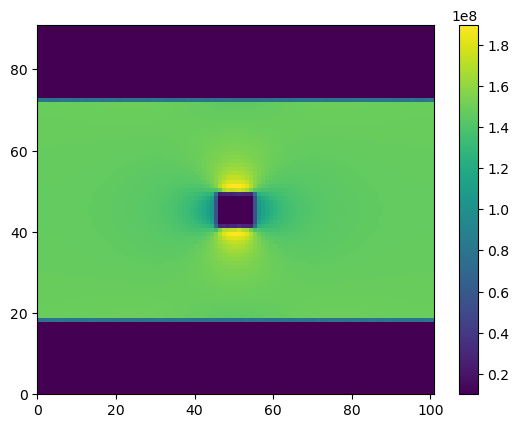

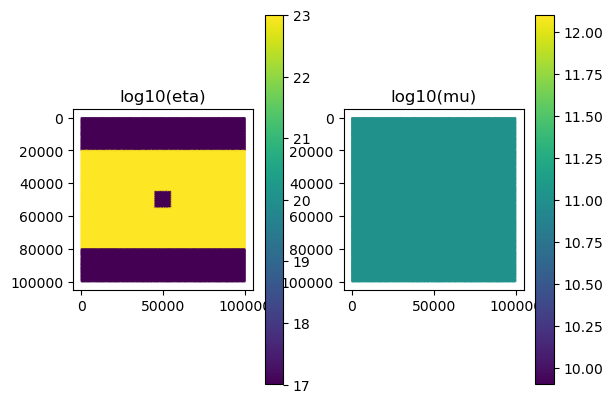

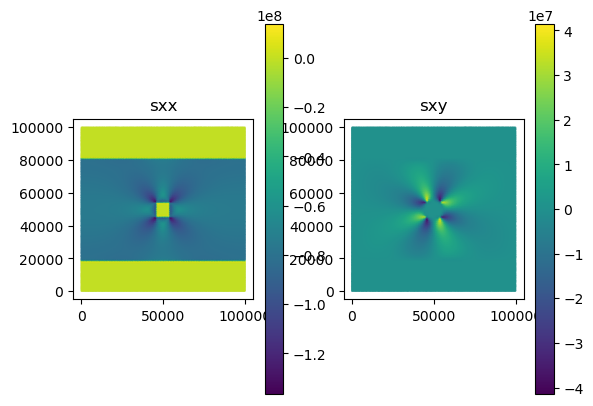

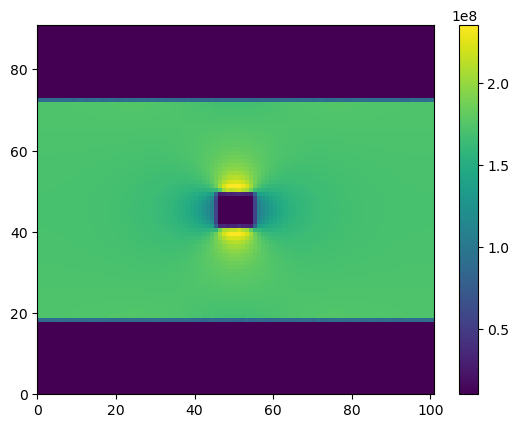

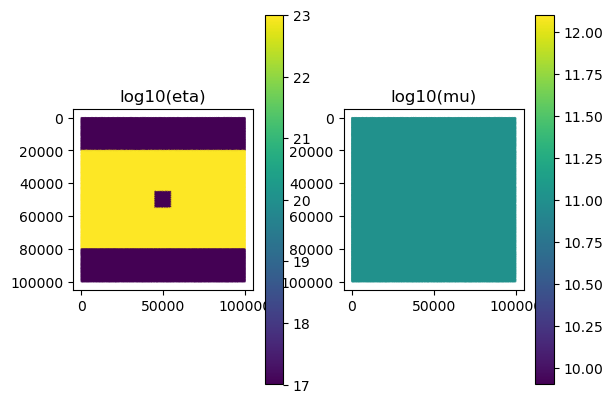

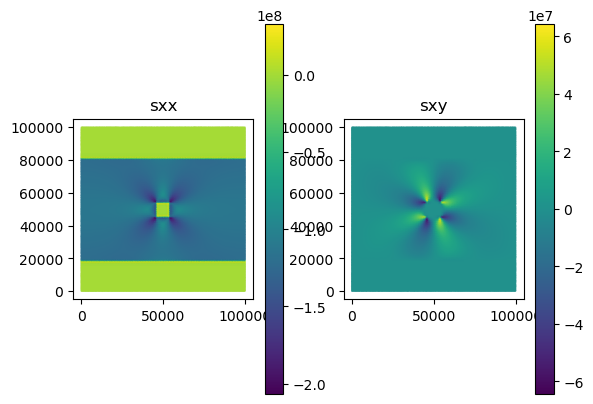

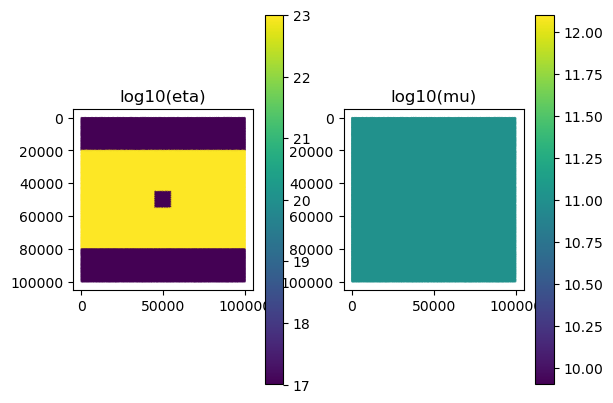

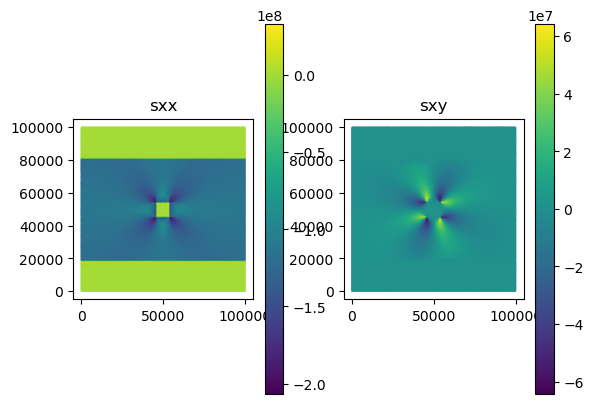

PyObject Text(0.5, 1.0, 'sxy')

In [18]:
# Main function - based on I2VIS notebook
function run(nstep::Int64)
    nx = 101
    ny = 91
    W = 1e5
    H = 1e5
    gx = 0.0
    gy = 0.0

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,0.0,0.0]
    boundary_velocity = 5e-9
    bc = BoundaryConditions(
        [1,1,-1,-1], # -1 means prescribed velocity
        [boundary_velocity,-boundary_velocity,0.0,0.0],
        [-1,-1,1,1],
        [0.0,0.0,-boundary_velocity,boundary_velocity]
        )
    # bc = BoundaryConditions([1,-1,boundary_velocity,0],[1,-1,-boundary_velocity,0.0],[-1,1,0.0,-boundary_velocity],[-1,1,0.0,boundary_velocity])
    materials = Materials()
    
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 100*seconds_in_year # plot interval in seconds
    end_time = 2e4*seconds_in_year
    dtmax = 100*seconds_in_year
    local grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    # Initialize the markers, including stress (sxx, sxy) and strain (exx, exy)
    @time markers = Markers(grid,["alpha","Cp","kThermal","rho","eta","Hr","mu","cohesion","friction","sxx","sxy","exx","exy"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)
    plot_material(markers)
    
    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 100*seconds_in_year
    nplast = 1

    local rho_c
    local rho_vx
    local rho_vy
    local alpha
    local Hr
    local Cp_c
    local eta_s
    local eta_n
    local vxc
    local vyc
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local vx
    local vy
    
    output_dir = "inclusion"
    for itime in 1:nstep
        
        timestep_factor = 1.0 # do not allow timestep to increase.
        
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic",method="arithmetic")
        mu_s, = marker_to_stag(markers,grid,["mu",],"basic",method="harmonic")
        sxy0, = marker_to_stag(markers,grid,["sxy",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,Hr_new,sxxo_new = marker_to_stag(markers,grid,["rho","Cp","alpha","Hr","sxx"],"center")
        mu_n, = marker_to_stag(markers,grid,["mu",],"center",method="harmonic")
        eta_n_new, = marker_to_stag(markers,grid,["eta",],"center",method="arithmetic")
        sxx0, = marker_to_stag(markers,grid,["sxx",],"center")
        # use special weighting when interpolating temperature
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        # Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        cohesion,friction = marker_to_stag(markers,grid,["cohesion","friction"],"basic")
        # Get material at basic nodes:
        #mat_node = marker_to_stag(markers,grid,markers.integers[markers.integerFields["material"],:],"basic");
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)            
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)        

        #1. Outer loop over (global) plastic iterations
        local sxx,sxy,exx,exy,w,vxc,vyc
        for iplast in 1:nplast
            
            # 2. Assemble and solve the stokes equations
            L,R,kcont = form_stokes(grid,eta_s,eta_n,mu_s,mu_n,sxx0,sxy0,rho_vx,rho_vy,bc,gx,gy;dt=dt)
            stokes_solution = L\R
            vx,vy,P = unpack(stokes_solution,grid,bc,kcont;ghost=true)
            # Compute the rotation rate
            w = compute_rotation(grid,vx,vy)
            vxc,vyc = velocity_to_centers(grid,vx,vy,bc)
            
            # 3. Compute the advection timestep:
            if itime > 1
                this_dtmax = min(timestep_factor*dt,dtmax)
            else
                this_dtmax = timestep_factor*dt
            end
            dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax,cfl=0.01)
            # Compute the stresses.
            exx,exy = compute_ve_strainrate(grid,vx,vy)
            sxx,sxy = compute_nodal_stress(eta_n,eta_s,mu_n,mu_s,sxx0,sxy0,exx,exy,dt)

            # Plastic yielding part
            # recompute the viscoplastic viscosity for yielding at the basic nodes
            # Gerya computes everything for plastic yielding on the basic nodes. This requires computing sxx values
            # on the ghost cells outside the domain. He assumes that dsxx/dn=0:
            sxx[:,grid.nx+1] .= sxx[:,grid.nx]
            sxx[:,1] .= sxx[:,2]
            sxx[1,:] .= sxx[2,:]
            sxx[grid.ny+1,:] .= sxx[grid.ny,:]
            # same for pressure - note that this is probably not the right thing to do if the model as nonzero gravity
            P[:,grid.nx+1] .= P[:,grid.nx]
            P[:,1] .= P[:,2]
            P[1,:] .= P[2,:]
            P[grid.ny+1,:] .= P[grid.ny,:]
            
            sii_s = zeros(grid.ny,grid.nx)
            Ps = zeros(grid.ny,grid.nx) # pressure at basic nodes
            for i in 1:grid.ny
                for j in 1:grid.nx
                    sii_s[i,j] = sqrt( sxy[i,j]^2 + ( (sxx[i,j]+sxx[i+1,j]+sxx[i,j+1]+sxx[i+1,j+1])/4.0)^2 )
                    Ps[i,j] = (P[i,j] + P[i,j+1] + P[i+1,j] + P[i+1,j+1])/4.0
                end
            end
            yield_stress = max.( cohesion .+ friction.*Ps , 0.0 )
            sii_elastic = sii_s.*( mu_s.*dt .+ eta_s )./eta_s
            # loop over the nodes and see if they're yielding
            # compute the yielding viscosity
            # check sii_elastic > yield stress
            # if yes, compute the plastic viscosity
            # update the plastic viscosity using Gerya's power-law update 
            # (note this was not described in the book but is transcribed from the matlab code)
            # etawt is the weight assigned to the old viscosity, set to 0 in the code. Presumably this can help with convergence.
            # apply the viscosity cutoff
            # update the yielding error

            
            figure()
            pcolor(yield_stress)
            colorbar()
        end # end the global plastic iterations
        
        # Interpolate stress change onto the markers
        dsxx = sxx.-sxx0
        dsxy = sxy.-sxy0
        cell_center_change_to_markers!(markers,grid,dsxx,"sxx")
        basic_node_change_to_markers!(markers,grid,dsxy,"sxy")

        if true || mod(itime,10) == 1
            plot_rheology(markers)
            plot_stress(markers)
            # if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)
            # visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))

        # compute the yielding on the markers and reduce viscosity as needed.
        
        
        # Advect and rotate stresses on the markers        
        move_markers_rk4!(markers,grid,bc,vx,vy,w,dt,continuity_weight=1/3)
        
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year," yr")
        # make the domain narrower/taller according to boundary velocity.
        grid = CartesianGrid(grid.W-2.0*boundary_velocity*dt,grid.H+2.0*boundary_velocity*dt,nx,ny,xstart=grid.x[1]+boundary_velocity*dt,ystart=grid.y[1]-boundary_velocity*dt)
        outflow_velocity = boundary_velocity*grid.H/grid.W
        bc = BoundaryConditions(
        [1,1,-1,-1], # -1 means prescribed velocity
        [boundary_velocity,-boundary_velocity,0.0,0.0],
        [-1,-1,1,1],
        [0.0,0.0,-outflow_velocity,outflow_velocity]
        )
    end
    return grid,markers,vx,vy,rho_c,eta_n,time
end
#@time coord,markers,vxc,vyc,rho_c,eta_n,t = run(201)
Profile.clear()
@time coord,markers,vx,vy,rho_c,eta_n,t = @profile run(3)
plot_rheology(markers)
plot_stress(markers)

In [6]:
figure()
pcolor(vx)
colorbar()
figure()
pcolor(vy)
colorbar()

LoadError: UndefVarError: `vx` not defined